# Predicting University Admission Using Logistic Regression

In this project, a logistic regression model is implemented to predict university admission outcomes based on applicants’ exam results.
Using historical admission data, the model estimates the probability of admission given scores from two exams.
Each data sample consists of two exam scores along with a binary admission decision, and the dataset is used to train a binary classification model that learns the relationship between exam performance and admission likelihood.

The following section loads the dataset and its corresponding labels.

In [1141]:
import pandas as pd
import numpy as np

In [1142]:
students = pd.read_csv("../data/student_exam_scores.csv", names=["First_Exam", "Second_Exam", "Admission_Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(students[["First_Exam", "Second_Exam"]])
y = np.array(students["Admission_Status"])

# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 100


### 🔍 Data Preview  
Displaying the first rows to verify the structure and ensure the labels (0/1) are correctly loaded.

In [1143]:
students.head()

,First_Exam,Second_Exam,Admission_Status
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1. Visualizing the data

Before implementing the logistic regression model, it is important to explore and visualize the dataset.
The dataset is visualized using the matplotlib library to examine the relationship between exam scores and admission outcomes.

In [1144]:
import matplotlib.pyplot as plt

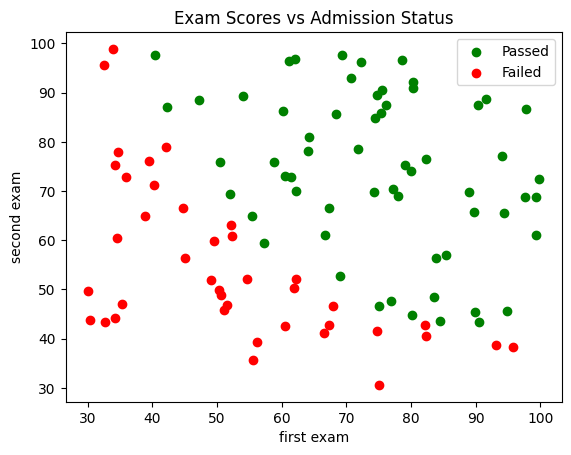

In [1145]:
# Separate students based on admission status
passed_students = students[students["Admission_Status"] == 1]
failed_students = students[students["Admission_Status"] == 0]

# Plot exam scores: green for passed, red for failed
plt.scatter(passed_students["First_Exam"], passed_students["Second_Exam"], color="green", label="Passed")
plt.scatter(failed_students["First_Exam"], failed_students["Second_Exam"], color="red", label="Failed")

# Add title, axis labels, and legend to visualize the relationship between exam scores and admission
plt.title("Exam Scores vs Admission Status")
plt.xlabel("first exam")
plt.ylabel("second exam")
plt.legend()
plt.show()

### 2. Implementation

#### 2.1 Sigmoid Function

The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x) $$

where $g$ is the sigmoid function. The sigmoid function is defined as:

$$ g(z) = \frac{1}{1+e^{-z}} $$

In this project, the first step is to implement the `sigmoid` function, which will be used throughout the program.  
The function should support scalar, vector, and matrix inputs, applying the sigmoid function element-wise.  

This function serves as the foundation for computing probabilities in logistic regression.


In [1146]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """

    g = 1 / (1 + np.exp(-z))
    return g

#### 2.2 Cost function and gradient

Now, the cost function and gradient for logistic regression are implemented.  
Before proceeding, an intercept term (bias) is added to the feature matrix \(X\).



In [1147]:
# --- Add intercept term (bias) ---
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)  # column of ones for theta_0

# --- Standardize features (exclude bias column) ---
# Compute mean and standard deviation of each feature (columns 1 and 2)
mean = X[:, 1:].mean(axis=0)
std = X[:, 1:].std(axis=0)

# Apply standardization
X[:, 1:] = (X[:, 1:] - mean) / std


The parameter $\theta_0$ represents the bias term in the model's weights.  

In this project, the function `cost_function` is implemented to compute the cost value, and `gradient_descent` is defined to return the gradient.  

The logistic regression cost function is defined as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$, with the $j^{th}$ element (for $j = 0, 1, \cdots , n$) given by:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Although the gradient formula looks similar to the linear regression gradient, it differs because the hypothesis function $h_\theta(x)$ is defined differently in logistic regression.


In [1148]:
def cost_function(theta, X, y):
    """
    Compute cost_function for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.
    """
    # 1. Prediction: Calculate the probability (h) for all samples at once
    h = sigmoid(X.dot(theta))
    
    # 2. Stability: Prevent log(0) which results in NaN (Not a Number)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    
    # 3. Vectorized Cost Calculation: 
    term1 = y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    
    J = - (1 / m) * np.sum(term1 + term2)
    
    return J

In [1149]:
def gradient_descent(theta, X, y):
    """
    Compute gradient_descent for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    # 1. Prediction: Compute probabilities using the sigmoid of X*theta
    h = sigmoid(X.dot(theta))
    
    # 2. Vectorized Gradient Calculation:
    grad = (1 / m) * X.T.dot(h - y)
    
    return grad

### Calculating the Optimal θ Using Stochastic Gradient Descent


In [1150]:

def train_using_sgd(theta, X, y, learning_rate=0.05, epochs=500):
    """
    Perform stochastic gradient descent to train the logistic regression model.
    """
    m = X.shape[0]  # number of samples
    for epoch in range(epochs):
        # Shuffle data at each epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(m):
            xi = X_shuffled[i]
            yi = y_shuffled[i]
            
            # Compute prediction for single sample
            h = sigmoid(np.dot(xi, theta))
            
            # Gradient for this sample
            grad = (h - yi) * xi
            
            # Update parameters
            theta -= learning_rate * grad

    return theta

# Initialize theta and train
theta = np.zeros(X.shape[1])
theta_optimized = train_using_sgd(theta, X, y)


### Plotting the Decision Boundary of the Logistic Regression Model Trained with Gradient Descent


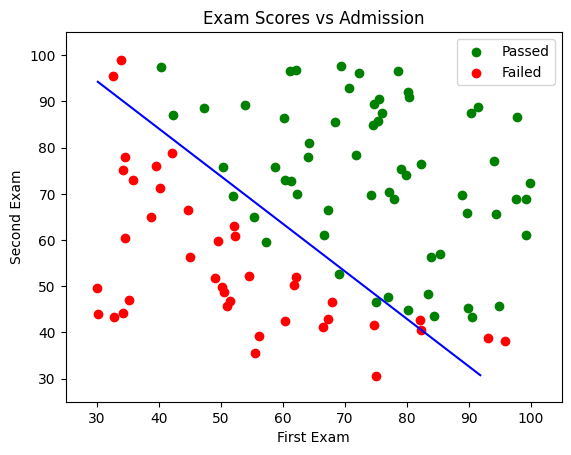

In [1151]:
# Generate a grid of points
x1 = np.linspace(students["First_Exam"].min(), students["First_Exam"].max(), 200)
x2 = np.linspace(students["Second_Exam"].min(), students["Second_Exam"].max(), 200)
xx1, xx2 = np.meshgrid(x1, x2)

# Flatten and standardize manually using the mean and std from training
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_scaled = (grid - mean) / std  # standardize like training
grid_scaled = np.c_[np.ones(grid_scaled.shape[0]), grid_scaled]  # add bias

# Compute probabilities
probs = sigmoid(grid_scaled.dot(theta_optimized)).reshape(xx1.shape)

# Plot
plt.scatter(passed_students["First_Exam"], passed_students["Second_Exam"], color="green", label="Passed")
plt.scatter(failed_students["First_Exam"], failed_students["Second_Exam"], color="red", label="Failed")

# Draw decision boundary (0.5 contour)
plt.contour(xx1, xx2, probs, levels=[0.5], colors='blue')

# Extend axis limits to better display high scores
plt.xlim(25, 105)
plt.ylim(25, 105)

plt.title("Exam Scores vs Admission")
plt.xlabel("First Exam")
plt.ylabel("Second Exam")
plt.legend()
plt.show()


#### 1.2.4 Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 53 and an Exam 2 score of 94, print the admission
probability.

In [1152]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.
    """
    predicted = np.zeros(m)
    predicted = np.round(sigmoid(X.dot(theta)))

    return predicted

In [1153]:
def accuracy(y_pred, y):
    """
    check prediction accuracy with comparison between predict and actual value
    if two parameter(predicted and actual value) are equal diff will be 0 and
    otherwise will be 1. count of nonzero devided by len of diff is errors. 1 minus
    error is our prediction accuracy

    Parameters
    ----------
    y_pred : array_like
        Predicted values that output of predict function.

    y : array_like
        Actual value of data, (Labels)

    Returns
    -------
    number : float
        model accuracy percentage
    """
    diff = y_pred - y
    errors_amount = np.count_nonzero(diff)
    accuracy = 1 - errors_amount / len(diff)
    return accuracy

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [1154]:
# Predict probability for a student with score 45 on exam 1
# and score 85 on exam 2

prob = sigmoid(np.array([1, 53, 94]).dot(theta_optimized))
print("admission probability {:.2f}".format(prob))

admission probability 1.00


plot the AUC and the ROC curve on your model


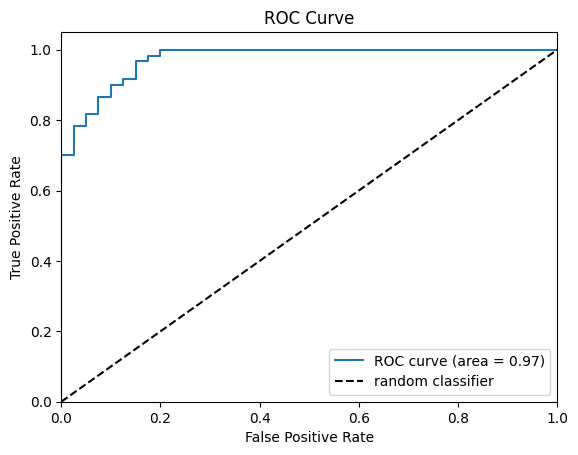

In [1155]:
from sklearn.metrics import roc_curve, auc

y_pred = sigmoid(np.dot(X, theta_optimized))
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()





```
# This is formatted as code
```

## Section 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

First, we load the data from a CSV file:

In [1156]:
microchips= pd.read_csv("ex2data2.txt", names=["First_Test", "Second_Test", "Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(microchips[["First_Test", "Second_Test"]])
y = np.array(microchips["Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

FileNotFoundError: [Errno 2] No such file or directory: 'ex2data2.txt'

### 2.1 Visualize the data

Similar to the previous parts of this exercise, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

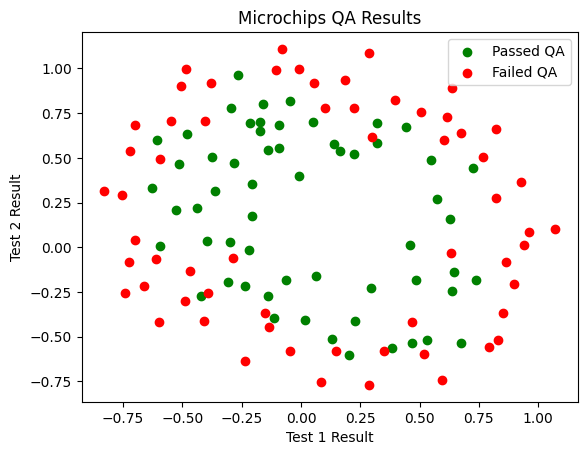

In [ ]:
passed_microchips = microchips[microchips["Status"] == 1]
failed_microchips = microchips[microchips["Status"] == 0]

plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], color="green", label="Passed QA")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], color="red", label="Failed QA")

plt.title("Microchips QA Results")
plt.xlabel("Test 1 Result")
plt.ylabel("Test 2 Result")
plt.legend()
plt.show()


The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{map_feature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.


In [ ]:
### make the map feature function

In [ ]:
def map_feature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.

    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.

    degree: int, optional
        The polynomial degree.

    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    array_like = []
    array_like.append(np.ones(X1.shape[0]))
    for i in range(1, degree + 1):
        for j in range(i + 1):
            new_col = (X1 ** (i - j)) * (X2 ** j)
            array_like.append(new_col)
    array_like = np.column_stack(array_like)
    return array_like


In [ ]:
X = map_feature(X[:,0], X[:,1])

### 2.3 Cost function and gradient
Note that the parameter $\theta_0$ represents the bias term in the model's weights.
Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `cost_function_gradient_descent_regularized` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$

In [ ]:
def cost_function_gradient_descent_regularized(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total
        number of polynomial features.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly
    J = cost_function(theta, X, y)
    sigma = 0
    for i in range(1, n):
        sigma += theta[i] ** 2
    sigma *= lambda_ / (2 * m)
    J += sigma

    grad = gradient_descent(theta, X, y)
    for i in range(1, n):
        grad[i] += (lambda_ / m) * theta[i]



    # =============================================================
    return J, grad

#### 2.3.1 Learning parameters using momentum

Similar to the previous parts, you will optimize the Regularized logistic regression using the momentum algorithm optimize the model with $\lambda = 1$, $\lambda = 0$

In [ ]:
def train_using_momentum(theta, X, y, learning_rate,beta,lmbda, epochs=500):
    """
    Perform gradient deacent with momentum to train the Regularized logistic regression model.
    """
    v = np.zeros(theta.shape)
    for epoch in range(epochs):
       indices = np.random.permutation(m)
       X_shuffled = X[indices]
       y_shuffled = y[indices]
       for i in indices:
          xi = X_shuffled[i]
          yi = y_shuffled[i]

          err = sigmoid(np.dot(xi, theta))
          err -= yi
          err *= xi
          grad = err
          sigma = np.r_[[0], theta[1:]]
          sigma *= (lmbda / m)
          grad += sigma


          v = beta * v + (1 - beta) * grad
          theta -= learning_rate * v



# Example usage:
# Assuming you have X, y, and theta initialized appropriately
# Train the logistic regression model using stochastic gradient descent

    return theta


In [ ]:
# Compute accuracy on our training set
initial_theta = np.zeros(X.shape[1])
theta_optimized = train_using_momentum(initial_theta, X, y, 0.01,0.9,1)
model_predicted = predict(theta_optimized, X)

print("Train Accuracy: {:.1f}".format((np.mean(model_predicted == y) * 100)))
print("Expected accuracy (with lambda = 1): 83.1 % (approx)\n")

Train Accuracy: 83.1
Expected accuracy (with lambda = 1): 83.1 % (approx)



### plot the decision boundery for $\lambda =1$




In [ ]:
pos = y == 1
neg = y == 0


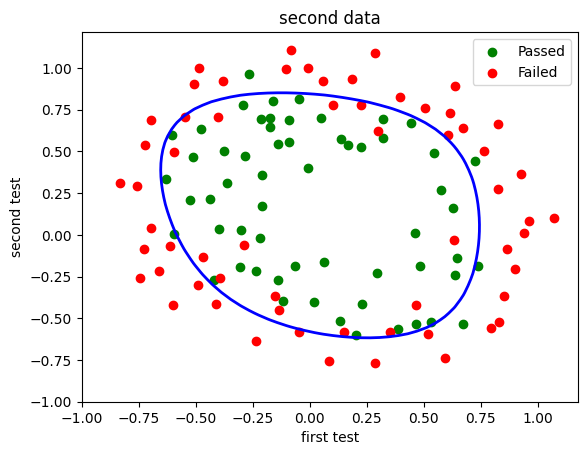

In [ ]:
plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], color="green", label="Passed")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], color="red", label="Failed")

theta_lamda1 = train_using_momentum(initial_theta, X, y, 0.01,0.9,1)

u = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)
z = np.zeros((50, 50))

for i in range(50):
    for j in range(50):
        features = map_feature(np.array([u[i]]), np.array([v[j]]))
        z[i, j] = np.dot(features, theta_lamda1).item()

z = z.T
plt.contour(u, v, z, levels=[0], linewidths=2, colors='b')


plt.title("second data")
plt.xlabel("first test")
plt.ylabel("second test")
plt.legend()
plt.show()

### plot the decision boundery for $\lambda=0$




In [ ]:
pos = y == 1
neg = y == 0



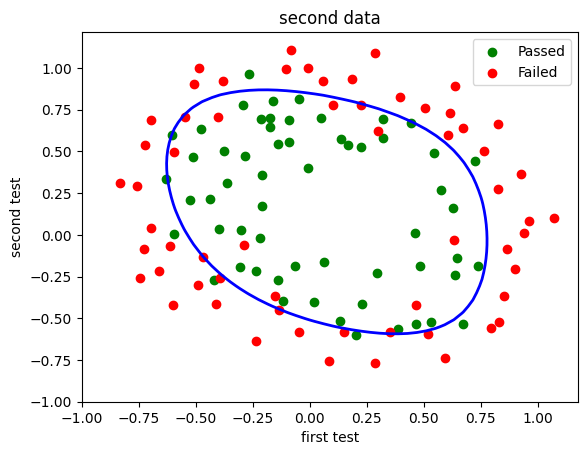

In [ ]:
plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], color="green", label="Passed")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], color="red", label="Failed")

theta_lamda1 = train_using_momentum(initial_theta, X, y, 0.01,0.9,0)

u = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)
z = np.zeros((50, 50))

for i in range(50):
    for j in range(50):
        features = map_feature(np.array([u[i]]), np.array([v[j]]))
        z[i, j] = np.dot(features, theta_lamda0).item()

z = z.T
plt.contour(u, v, z, levels=[0], linewidths=2, colors='b')


plt.title("second data")
plt.xlabel("first test")
plt.ylabel("second test")
plt.legend()
plt.show()